In [1]:
import numpy as np
import pandas as pd
import tqdm
from copy import copy
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score
%matplotlib inline

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.constraints import Constraint
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

In [2]:
data = pd.read_table('data/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt', sep=',', nrows=100000, header=None, comment=';')

In [3]:
header = ['user', 'activity', 'timestamp', 'x-acceleration', 'y-accel', 'z-accel']
data.columns = header

In [4]:
data.head()

,user,activity,timestamp,x-acceleration,y-accel,z-accel
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [5]:
activitys = set(data['activity'])
coords = ['x-acceleration', 'y-accel', 'z-accel']

In [6]:
scaler = StandardScaler()
scaler.fit(data[coords])
norm_data = copy(data)
norm_data[coords] = scaler.transform(data[coords])

In [7]:
data_per_user = {user : data.loc[data['user'] == user] for user in set(data['user'])}
norm_data_per_user = {user : norm_data.loc[data['user'] == user] for user in set(data['user'])}

Walking


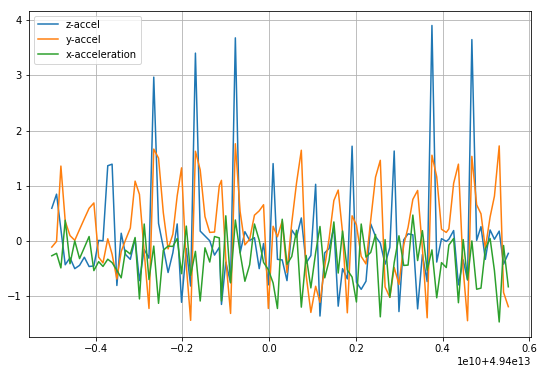

Downstairs


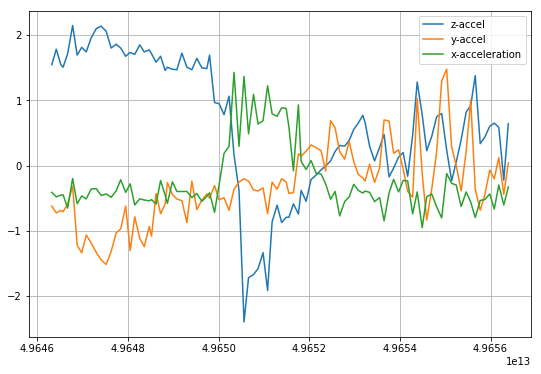

Jogging


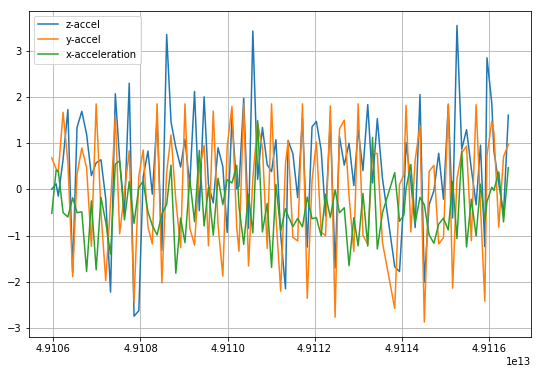

Upstairs


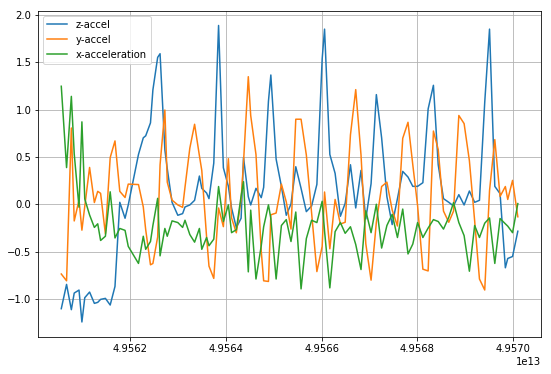

In [8]:
for activity in activitys:
    print(activity)
    curr_data = norm_data_per_user[33].loc[data_per_user[33]['activity'] == activity]
    plt.figure(figsize=(9, 6))
    plt.plot(curr_data['timestamp'][:100], curr_data['z-accel'][:100])
    plt.plot(curr_data['timestamp'][:100], curr_data['y-accel'][:100])
    plt.plot(curr_data['timestamp'][:100], curr_data['x-acceleration'][:100])
    plt.legend()
    plt.grid()
    plt.show()

In [93]:
norm_data[['activity']] = LabelEncoder().fit_transform(norm_data[['activity']])

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [12]:
Y = norm_data[['activity']]

encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
dummy_y = np_utils.to_categorical(encoded_Y)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [14]:
new_Y = pd.DataFrame(dummy_y, index=norm_data.index, columns=[0, 1, 2, 3])

In [15]:
new_Y.head()

,0,1,2,3
0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0


In [21]:
norm_data = norm_data.drop(labels=['activity'], axis=1)
norm_data = pd.concat([norm_data, new_Y], axis=1)
norm_data.head()

,user,timestamp,x-acceleration,y-accel,z-accel,0,1,2,3
0,33,49105962326000,-0.517624,0.682915,0.004632,0.0,1.0,0.0,0.0
1,33,49106062271000,0.412574,0.442624,0.120235,0.0,1.0,0.0,0.0
2,33,49106112167000,0.394813,0.377930,-0.146001,0.0,1.0,0.0,0.0
3,33,49106222305000,-0.504303,1.669493,0.652706,0.0,1.0,0.0,0.0
4,33,49106332290000,-0.597545,0.585874,1.728157,0.0,1.0,0.0,0.0


In [28]:
class CustomConstraint(Constraint):
    def __init__(self, W0):
        self.W0 = W0
        
    def __call__(self, w):
        new_w = self.W0 * w
        return new_w

In [32]:
X = norm_data.drop([0, 1, 2, 3], axis=1)
Y = new_Y

In [38]:
# N --- количство итераций в случайном поиске
N = 50
# здесь задается вероятность наличия связи между нейронами соседних уровней. Берем ее за 0.2
proba_of_one = 0.2
proba_of_zero = 0.8
p = [proba_of_zero, proba_of_one]
# делим исходные данные на 10 частей
step = len(X) // 10 

optimas = []

for start in tqdm.tqdm_notebook(range(0, len(X), step)):
    optima, W0_opt, W1_opt, best_metric = None, None, None, 0
    X_curr, Y_curr = X[start : start + step], Y[start : start + step]
    X_train, X_test, y_train, y_test = train_test_split(X_curr, Y_curr, test_size=0.2, random_state=42)
    
    for _ in tqdm.tqdm_notebook(range(N)):
        # W0 --- матрица первого слоя, W1 --- матрица второго слоя
        W0 = np.random.choice([0, 1], size=(5, 5), p=p)
        W1 = np.random.choice([0, 1], size=(5, 4), p=p)

        model = Sequential()
        model.add(Dense(5, input_dim=5, kernel_constraint=CustomConstraint(W0)))
        model.add(Dense(4, activation='sigmoid', kernel_constraint=CustomConstraint(W1)))
        model.compile(optimizer='rmsprop',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

        model.fit(X_train, y_train, verbose=0)
        loss, metric = model.evaluate(X_test, y_test, verbose=0)

        if metric > best_metric:
            best_metric = metric
            optima = copy(model)
            W0_opt, W1_opt = W0, W1

    print('best_metric =', best_metric)
    optimas.append((optima, W0_opt, W1_opt, best_metric))

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

best_metric = 0.7515


HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

best_metric = 0.868375


HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

best_metric = 0.81


HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

best_metric = 0.82375


HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

best_metric = 0.761


HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

best_metric = 0.8815


HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

best_metric = 1.0


HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

best_metric = 0.81325


HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

best_metric = 0.7815


HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

best_metric = 0.761



В optimas лежат 10 tuple-ов, i-ый соответствует куску данных $\left[10^4 \cdot i;  10^4 \cdot (i + 1)\right)$ и хранит в себе:
* 0-ая позиция - модель
* 1,2-ая позиции - матрицы-индикаторы наличия связи в первом$(5 \times 5)$ и втором $(5 \times 4)$ уровне
* 4-ая позиция - качество на 20% текущей подвыборки

У модели есть поле .layers, и у i-го слоя метод .get_weights() возвращает матрицу весов. По ней можно убедиться, что остались только те веса, которые задавались матрицей сооответсвующего уровня.
Для примера: матрица весов на третьей доле данных для первого слоя и ее "маска":

In [43]:
optimas[3][0].layers[0].get_weights()

[array([[ 0.        ,  0.        , -0.        , -0.        ,  0.        ],
        [ 0.        ,  0.        , -0.        ,  0.        ,  0.        ],
        [-0.        , -0.3998904 ,  0.        ,  0.5223919 , -0.6086038 ],
        [ 0.5953401 ,  0.00524428, -0.        , -0.        ,  0.        ],
        [ 0.        ,  0.        , -0.        , -0.        ,  0.        ]],
       dtype=float32),
 array([-0.1643777 , -0.17327276,  0.00316223,  0.00316223, -0.18257578],
       dtype=float32)]

In [44]:
optimas[3][1]

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 1, 0, 1, 1],
       [1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0]])